In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### random forest

In [2]:
def RandomForestC(train_x, test_x, train_y, test_y, config):
    
    clf = RandomForestClassifier(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def RandomForestR(train_x, test_x, train_y, test_y, config):
    
    clf = RandomForestRegressor(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def runall_ForestC(num_set, trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = RandomForestC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})

    return table_set
    
    
def runall_ForestR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = RandomForestR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### optuna

In [3]:
def RandomForest_creator(train_data, mode, num_valid = 3) :
    
    def objective(trial) :

        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800, step = 100),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 32, step = 5),
            'max_depth': trial.suggest_int('max_depth', 3, 21, step = 3),
            #'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
            #'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 2), # alpha
            #'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 2) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = RandomForestC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                aging = table['Aging Rate']
                effi = table['Efficiency']
                result_list.append(recall - 0.1*aging)

            elif mode == 'R':
                result = RandomForestR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

## 

### loading training & testing data

In [4]:
### training data ### 
training_month = range(1, 7)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 1:

Dimension of dataset 0 : (17735, 84)  balance ratio: 1181.0
Dimension of dataset 1 : (296, 84)  balance ratio: 1.0
Dimension of dataset 2 : (420, 84)  balance ratio: 1.0
Dimension of dataset 3 : (328, 84)  balance ratio: 1.0
Dimension of dataset 4 : (300, 84)  balance ratio: 1.0
Dimension of dataset 5 : (298, 84)  balance ratio: 1.0
Dimension of dataset 6 : (370, 84)  balance ratio: 1.0
Dimension of dataset 7 : (300, 84)  balance ratio: 1.0
Dimension of dataset 8 : (300, 84)  balance ratio: 1.0
Dimension of dataset 9 : (165, 84)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 2:

Dimension of dataset 0 : (39009, 90)  balance ratio: 533.0
Dimension of dataset 1 : (1460, 90)  balance ratio: 1.0
Dimension of dataset 2 : (1908, 90)  balance ratio: 1.0
Dimension of dataset 3 : (1604, 90)  balance ratio: 1.0
Dimension of dataset 4 : (1460, 90)  balance ratio: 1.0
Dimension of dataset 5 : (1465, 90)  balance ratio: 1.0
Dimension of dataset

### search for best hyperparameter

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 50, 
                                     filename = 'runhist_array_m1m6_m7_3criteria_RandomForest', 
                                     creator = RandomForest_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 01:52:21,022] A new study created in memory with name: no-name-37428456-c253-416d-9155-2c58520748f0


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.01818181818181818 
Aging Rate: 3.458352786567758e-05
Precision: 1.0 
Recall: 0.007751937984496124 
Aging Rate: 1.729176393283879e-05
Precision: 1.0 
Recall: 0.025423728813559324 
Aging Rate: 5.187529179851637e-05
[I 2021-11-20 01:52:40,911] Trial 0 finished with value: 0.01711570330717131 and parameters: {'n_estimators': 200, 'min_samples_split': 7, 'max_depth': 12}. Best is trial 0 with value: 0.01711570330717131.
Precision: 0.8181818181818182 
Recall: 0.15254237288135594 
Aging Rate: 0.00038041880652245336
Precision: 0.96 
Recall: 0.18461538461538463 
Aging Rate: 0.0004322940983209697
Precision: 0.8571428571428571 
Recall: 0.14516129032258066 
Aging Rate: 0.00036312704258961454
[I 2021-11-20 01:53:35,965] Trial 1 finished with value: 0.16073382127485933 and parameters: {'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 1 with value: 0.16073382127485933.
Precision: 0.8 
Recall: 0.1111111111111111 
Aging Rate: 0.0002593764589925818
P

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 01:55:30,490] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 800, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 1 with value: 0.16073382127485933.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 01:55:44,360] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 400, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 1 with value: 0.16073382127485933.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 01:55:55,134] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 300, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 1 with value: 0.16073382127485933.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 01:56:33,146] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 9}. Best is trial 1 with value: 0.16073382127485933.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 01:56:53,508] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 600, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 1 with value: 0.16073382127485933.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 01:58:02,849] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 700, 'min_samples_split': 17, 'max_depth': 15}. Best is trial 1 with value: 0.16073382127485933.
Precision: 0.8518518518518519 
Recall: 0.18548387096774194 
Aging Rate: 0.0004668776261866473
Precision: 0.8333333333333334 
Recall: 0.22321428571428573 
Aging Rate: 0.0005187529179851636
Precision: 0.88 
Recall: 0.16666666666666666 
Aging Rate: 0.0004322940983209697
[I 2021-11-20 01:59:26,502] Trial 9 finished with value: 0.19174101029481502 and parameters: {'n_estimators': 800, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 9 with value: 0.19174101029481502.
Precision: 0.9166666666666666 
Recall: 0.09401709401709402 
Aging Rate: 0.00020750116719406547
Precision: 0.9285714285714286 
Recall: 0.10317460317460317 
Aging Rate: 0.00024208469505974305
Precision: 0.6923076923076923 
Recall: 0.07563025210084033 
Aging Rate: 0.00022479293112690426
[I 2021

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:03:00,967] Trial 12 finished with value: 0.006019912832192796 and parameters: {'n_estimators': 800, 'min_samples_split': 17, 'max_depth': 21}. Best is trial 11 with value: 0.29094489000086227.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:03:39,204] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 11 with value: 0.29094489000086227.
Precision: 0.9117647058823529 
Recall: 0.5636363636363636 
Aging Rate: 0.0011758399474330375
Precision: 0.8615384615384616 
Recall: 0.5045045045045045 
Aging Rate: 0.0011239646556345214
Precision: 0.8428571428571429 
Recall: 0.5315315315315315 
Aging Rate: 0.0012104234752987153
[I 2021-11-20 02:05:03,115] Trial 14 finished with value: 0.5331071256215211 and parameters: {'n_estimators': 800, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 14 with value: 0.5331071256215211.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:05:45,870] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 400, 'min_samples_split': 32, 'max_depth': 21}. Best is trial 14 with value: 0.5331071256215211.
Precision: 0.875 
Recall: 0.11570247933884298 
Aging Rate: 0.0002766682229254206
Precision: 0.7058823529411765 
Recall: 0.11214953271028037 
Aging Rate: 0.0002939599868582594
Precision: 1.0 
Recall: 0.09482758620689655 
Aging Rate: 0.00019020940326122668
[I 2021-11-20 02:06:35,654] Trial 16 finished with value: 0.1075345048315718 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 14 with value: 0.5331071256215211.
Precision: 0.9411764705882353 
Recall: 0.24806201550387597 
Aging Rate: 0.0005879199737165188
Precision: 0.9743589743589743 
Recall: 0.3333333333333333 
Aging Rate: 0.0006743787933807128
Precision: 1.0 
Recall: 0.3153153153153153 
Aging Rate: 0.0006052117376493576
[I 2021-11-20 02:06:57,966] Trial 17 fi

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:07:34,054] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 21}. Best is trial 19 with value: 0.5601828129573795.
Precision: 0.9180327868852459 
Recall: 0.5137614678899083 
Aging Rate: 0.001054797599903166
Precision: 0.9473684210526315 
Recall: 0.5142857142857142 
Aging Rate: 0.0013141740588957479
Precision: 0.9552238805970149 
Recall: 0.5925925925925926 
Aging Rate: 0.0011585481835001989
[I 2021-11-20 02:07:45,914] Trial 21 finished with value: 0.5400956742613284 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 19 with value: 0.5601828129573795.
Precision: 1.0 
Recall: 0.032 
Aging Rate: 6.916705573135516e-05
Precision: 0.5 
Recall: 0.016 
Aging Rate: 6.916705573135516e-05
Precision: 0.8 
Recall: 0.034782608695652174 
Aging Rate: 8.645881966419394e-05
[I 2021-11-20 02:07:57,587] Trial 22 finished with value: 0.02758670980

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:10:22,409] Trial 26 finished with value: 0.0 and parameters: {'n_estimators': 700, 'min_samples_split': 32, 'max_depth': 15}. Best is trial 19 with value: 0.5601828129573795.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:10:33,392] Trial 27 finished with value: 0.0 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 3}. Best is trial 19 with value: 0.5601828129573795.
Precision: 0.9024390243902439 
Recall: 0.25170068027210885 
Aging Rate: 0.0007089623212463903
Precision: 0.8478260869565217 
Recall: 0.29770992366412213 
Aging Rate: 0.0007954211409105842
Precision: 0.918918918918919 
Recall: 0.27419354838709675 
Aging Rate: 0.0006397952655150352
[I 2021-11-20 02:10:45,167] Trial 28 finished with value: 0.2744632448168535 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 19 with value: 0.5601828129573795.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:11:13,018] Trial 29 finished with value: 0.0 and parameters: {'n_estimators': 300, 'min_samples_split': 32, 'max_depth': 12}. Best is trial 19 with value: 0.5601828129573795.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:11:23,411] Trial 30 finished with value: 0.0 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 19 with value: 0.5601828129573795.
Precision: 0.8192771084337349 
Recall: 0.5666666666666667 
Aging Rate: 0.0014352164064256195
Precision: 0.8115942028985508 
Recall: 0.509090909090909 
Aging Rate: 0.0011931317113658764
Precision: 0.8939393939393939 
Recall: 0.4796747967479675 
Aging Rate: 0.00114125641956736
[I 2021-11-20 02:12:37,412] Trial 31 finished with value: 0.5183518040172691 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 19 with value: 0.5601828129573795.
Precision: 0.8214285714285714 
Recall: 0.15436241610738255 
Aging Rate: 0.0004841693901194861
Precision: 0.8571428571428571 
Recall: 0.15254237288135594 
Aging Rate: 0.00036312704258961454
Precision: 0.8 
Recall: 0.2033898305084746 
Aging Rate: 0.0005187529179851636
[I 2021-11-20 02

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:18:48,938] Trial 43 finished with value: 0.0 and parameters: {'n_estimators': 800, 'min_samples_split': 22, 'max_depth': 3}. Best is trial 36 with value: 0.5605424163868581.
Precision: 0.9466666666666667 
Recall: 0.5725806451612904 
Aging Rate: 0.0012968822949629092
Precision: 0.9315068493150684 
Recall: 0.5714285714285714 
Aging Rate: 0.0012622987670972317
Precision: 0.9714285714285714 
Recall: 0.4927536231884058 
Aging Rate: 0.0012104234752987153
[I 2021-11-20 02:19:31,923] Trial 44 finished with value: 0.5454619597748439 and parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 36 with value: 0.5605424163868581.
Precision: 0.8918918918918919 
Recall: 0.55 
Aging Rate: 0.0012795905310300703
Precision: 0.9666666666666667 
Recall: 0.4496124031007752 
Aging Rate: 0.0010375058359703272
Precision: 0.9104477611940298 
Recall: 0.5213675213675214 
Aging Rate: 0.0011585481835001989
[I 2021-11-20 02

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:20:49,716] Trial 47 finished with value: 0.0 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 36 with value: 0.5605424163868581.
Precision: 0.9538461538461539 
Recall: 0.5344827586206896 
Aging Rate: 0.0011239646556345214
Precision: 0.9264705882352942 
Recall: 0.5431034482758621 
Aging Rate: 0.0011758399474330375
Precision: 0.847457627118644 
Recall: 0.42016806722689076 
Aging Rate: 0.0010202140720374886
[I 2021-11-20 02:21:32,820] Trial 48 finished with value: 0.49914075741864394 and parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 36 with value: 0.5605424163868581.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:21:37,590] A new study created in memory with name: no-name-8b97f943-a8c5-4b54-84af-334621817e32


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:21:37,550] Trial 49 finished with value: 0.0 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 3}. Best is trial 36 with value: 0.5605424163868581.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9305912596401028 
Recall: 0.9180050718512257 
Aging Rate: 0.48889819857561795
Precision: 0.9328097731239092 
Recall: 0.9168096054888508 
Aging Rate: 0.4801005446166737
Precision: 0.9301310043668122 
Recall: 0.892707460184409 
Aging Rate: 0.4796816087138668
[I 2021-11-20 02:21:39,642] Trial 0 finished with value: 0.8608847007779565 and parameters: {'n_estimators': 400, 'min_samples_split': 17, 'max_depth': 6}. Best is trial 0 with value: 0.8608847007779565.
Precision: 0.9932885906040269 
Recall: 0.974485596707819 
Aging Rate: 0.4993715961457897
Precision: 0.9898305084745763 
Recall: 0.9782244556113903 
Aging Rate: 0.49434436531210724
Precision: 0.9885807504078303 
Recall: 0.9813765182186235 
Aging Rate: 0.5136154168412232
[I 2021-11-20 02:21:40,867] Trial 1 finished with value: 0.9277844775693068 and parameters: {'n_estimators': 200, 'min_samples_split': 7, 'max_depth': 12}. Best is trial 1 with value: 0.9277844775693068.
Precision: 0.9974380871050385 
Recall: 0.99235344095

Precision: 0.9906937394247038 
Recall: 0.9881856540084388 
Aging Rate: 0.49518223711772097
Precision: 0.9948453608247423 
Recall: 0.985531914893617 
Aging Rate: 0.4876413908671973
Precision: 0.9933333333333333 
Recall: 0.9851239669421488 
Aging Rate: 0.5027230833682447
[I 2021-11-20 02:22:15,701] Trial 17 finished with value: 0.936762288236296 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 2 with value: 0.9413762162983322.
Precision: 0.9917898193760263 
Recall: 0.9853181076672104 
Aging Rate: 0.5102639296187683
Precision: 0.992320819112628 
Recall: 0.9822635135135135 
Aging Rate: 0.4909928780896523
Precision: 0.9908789386401327 
Recall: 0.9787059787059788 
Aging Rate: 0.5052366987850859
[I 2021-11-20 02:22:18,750] Trial 18 finished with value: 0.9318794164124506 and parameters: {'n_estimators': 600, 'min_samples_split': 22, 'max_depth': 18}. Best is trial 2 with value: 0.9413762162983322.
Precision: 0.9957228400342173 
Recall: 0.9781512605

Precision: 0.9949409780775716 
Recall: 0.9932659932659933 
Aging Rate: 0.4968579807289485
Precision: 0.9967023907666942 
Recall: 0.9885527391659853 
Aging Rate: 0.508169250104734
Precision: 0.9940577249575552 
Recall: 0.9906937394247038 
Aging Rate: 0.4935064935064935
[I 2021-11-20 02:22:51,764] Trial 34 finished with value: 0.9408863664742215 and parameters: {'n_estimators': 200, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 26 with value: 0.9421107616299222.
Precision: 0.9957482993197279 
Recall: 0.9923728813559322 
Aging Rate: 0.49266862170087977
Precision: 0.9949748743718593 
Recall: 0.991652754590985 
Aging Rate: 0.5002094679514034
Precision: 0.9948979591836735 
Recall: 0.9906858594411516 
Aging Rate: 0.49266862170087977
[I 2021-11-20 02:22:53,444] Trial 35 finished with value: 0.9420522747509175 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 26 with value: 0.9421107616299222.
Precision: 0.9940323955669225 
Recall: 0.9881355

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:23:22,037] A new study created in memory with name: no-name-be5d3da2-6b25-4e25-8a8a-69baa83d8d1f


Precision: 0.9849498327759197 
Recall: 0.980849292256453 
Aging Rate: 0.5010473397570172
[I 2021-11-20 02:23:21,990] Trial 49 finished with value: 0.9286214431554979 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 21}. Best is trial 41 with value: 0.9424597726965196.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.988542329726289 
Recall: 0.967601246105919 
Aging Rate: 0.5006373486297004
Precision: 0.9832366215344939 
Recall: 0.978818998716303 
Aging Rate: 0.494263862332696
Precision: 0.9802295918367347 
Recall: 0.9642409033877039 
Aging Rate: 0.4996813256851498
[I 2021-11-20 02:23:23,280] Trial 0 finished with value: 0.9204009648483904 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 0 with value: 0.9204009648483904.
Precision: 0.8778311599176389 
Recall: 0.8136132315521628 
Aging Rate: 0.464308476736775
Precision: 0.8753369272237197 
Recall: 0.8386055519690123 
Aging Rate: 0.47291268323773106
Precision: 0.8714285714285714 
Recall: 0.8092229943145925 
Aging Rate: 0.4684512428298279
[I 2021-11-20 02:23:25,765] Trial 1 finished with value: 0.7736248458517782 and parameters: {'n_estimators': 600, 'min_samples_split': 27, 'max_depth': 6}. Best is trial 0 with value: 0.9204009648483904.
Precision: 0.9777922926192031 
Recall: 0.96767937944408

Precision: 0.9842370744010088 
Recall: 0.9744069912609239 
Aging Rate: 0.5054174633524537
Precision: 0.9757343550446999 
Recall: 0.9820051413881749 
Aging Rate: 0.49904397705544934
Precision: 0.9749679075738126 
Recall: 0.9712276214833759 
Aging Rate: 0.4964945825366475
[I 2021-11-20 02:24:11,689] Trial 17 finished with value: 0.9258480506126733 and parameters: {'n_estimators': 500, 'min_samples_split': 32, 'max_depth': 18}. Best is trial 10 with value: 0.9408201565973804.
Precision: 0.9813384813384813 
Recall: 0.9832366215344939 
Aging Rate: 0.49521988527724664
Precision: 0.9772870662460568 
Recall: 0.9878826530612245 
Aging Rate: 0.5050987890376035
Precision: 0.9782608695652174 
Recall: 0.9883720930232558 
Aging Rate: 0.4984066284257489
[I 2021-11-20 02:24:14,521] Trial 18 finished with value: 0.9365396124483046 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 10 with value: 0.9408201565973804.
Precision: 0.978021978021978 
Recall: 0.9780

Precision: 0.9811443433029909 
Recall: 0.9856303069888962 
Aging Rate: 0.49012109623964306
Precision: 0.9866071428571429 
Recall: 0.9847231063017187 
Aging Rate: 0.4996813256851498
Precision: 0.9872530274059911 
Recall: 0.981000633312223 
Aging Rate: 0.5
[I 2021-11-20 02:25:10,809] Trial 34 finished with value: 0.9341246014701196 and parameters: {'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 31 with value: 0.9420485355596591.
Precision: 0.983670803396473 
Recall: 0.9888378200919238 
Aging Rate: 0.4878903760356915
Precision: 0.9801849405548216 
Recall: 0.9808327825512227 
Aging Rate: 0.4824729126832377
Precision: 0.9820051413881749 
Recall: 0.9858064516129033 
Aging Rate: 0.4958572339069471
[I 2021-11-20 02:25:13,160] Trial 35 finished with value: 0.9362850006644875 and parameters: {'n_estimators': 400, 'min_samples_split': 22, 'max_depth': 21}. Best is trial 31 with value: 0.9420485355596591.
Precision: 0.9816687737041719 
Recall: 0.9866581956797967 
Agin

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:25:49,913] A new study created in memory with name: no-name-37367150-03bb-4238-8fc0-b590ad1ee0ec


Precision: 0.9840662842574889 
Recall: 0.9910141206675225 
Aging Rate: 0.5
[I 2021-11-20 02:25:49,866] Trial 49 finished with value: 0.9416067301467116 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 42 with value: 0.9420561989258588.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9207459207459208 
Aging Rate: 0.44903372489579385
Precision: 1.0 
Recall: 0.9039634146341463 
Aging Rate: 0.449412656309208
Precision: 1.0 
Recall: 0.911921032649962 
Aging Rate: 0.4550966275104206
[I 2021-11-20 02:25:52,350] Trial 0 finished with value: 0.8670920223861623 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 0 with value: 0.8670920223861623.
Precision: 1.0 
Recall: 0.916793893129771 
Aging Rate: 0.4550966275104206
Precision: 1.0 
Recall: 0.918007662835249 
Aging Rate: 0.4539598332701781
Precision: 1.0 
Recall: 0.9279757391963609 
Aging Rate: 0.4638120500189466
[I 2021-11-20 02:25:53,617] Trial 1 finished with value: 0.8751634813604755 and parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 1 with value: 0.8751634813604755.
Precision: 1.0 
Recall: 0.9161048689138577 
Aging Rate: 0.4634331186055324
Precision: 1.0 
Recall: 0.9046529366895499 
Aging Rate: 0.449412656309

Precision: 1.0 
Recall: 0.9092295957284515 
Aging Rate: 0.45168624478969305
Precision: 1.0 
Recall: 0.9138062547673532 
Aging Rate: 0.4539598332701781
Precision: 1.0 
Recall: 0.8984432913269088 
Aging Rate: 0.45926487305797653
[I 2021-11-20 02:26:38,873] Trial 19 finished with value: 0.8616626822369763 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 12}. Best is trial 13 with value: 0.9058454012044669.
Precision: 1.0 
Recall: 0.9348159509202454 
Aging Rate: 0.4619173929518757
Precision: 1.0 
Recall: 0.9336850037678975 
Aging Rate: 0.46949602122015915
Precision: 1.0 
Recall: 0.9547546012269938 
Aging Rate: 0.4717696097006442
[I 2021-11-20 02:26:42,730] Trial 20 finished with value: 0.8943124178426229 and parameters: {'n_estimators': 800, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 13 with value: 0.9058454012044669.
Precision: 1.0 
Recall: 0.9448275862068966 
Aging Rate: 0.4672224327396741
Precision: 1.0 
Recall: 0.9414483821263482 
Aging Rate: 0.4

Precision: 1.0 
Recall: 0.9390708301599391 
Aging Rate: 0.4672224327396741
Precision: 1.0 
Recall: 0.9450980392156862 
Aging Rate: 0.4566123531640773
Precision: 1.0 
Recall: 0.942572741194487 
Aging Rate: 0.4664645699128458
[I 2021-11-20 02:27:47,546] Trial 38 finished with value: 0.8959038916628175 and parameters: {'n_estimators': 700, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 32 with value: 0.9066008106488687.
Precision: 1.0 
Recall: 0.9114703618167821 
Aging Rate: 0.4486547934823797
Precision: 1.0 
Recall: 0.9116963594113091 
Aging Rate: 0.4460022735884805
Precision: 1.0 
Recall: 0.9089529590288316 
Aging Rate: 0.4539598332701781
[I 2021-11-20 02:27:49,205] Trial 39 finished with value: 0.8657526634076064 and parameters: {'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 15}. Best is trial 32 with value: 0.9066008106488687.
Precision: 1.0 
Recall: 0.9048349961627015 
Aging Rate: 0.4467601364153088
Precision: 1.0 
Recall: 0.9236058059587471 
Aging Rate: 0.45812

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:28:18,246] A new study created in memory with name: no-name-b12e637e-4da8-4aba-83d4-d605a0b05da0


Precision: 1.0 
Recall: 0.8884702336096458 
Aging Rate: 0.4467601364153088
[I 2021-11-20 02:28:18,199] Trial 49 finished with value: 0.8476314156711743 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 32 with value: 0.9066008106488687.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9973357015985791 
Recall: 0.9319502074688797 
Aging Rate: 0.4681912681912682
Precision: 0.9937555753791257 
Recall: 0.9456706281833617 
Aging Rate: 0.46611226611226614
Precision: 0.9964757709251101 
Recall: 0.9544303797468354 
Aging Rate: 0.47193347193347196
[I 2021-11-20 02:28:19,067] Trial 0 finished with value: 0.8971425049251254 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 12}. Best is trial 0 with value: 0.8971425049251254.
Precision: 0.9956784788245462 
Recall: 0.9560165975103735 
Aging Rate: 0.4810810810810811
Precision: 0.9958333333333333 
Recall: 0.9598393574297188 
Aging Rate: 0.498960498960499
Precision: 0.9949066213921901 
Recall: 0.9582992641046607 
Aging Rate: 0.48981288981288984
[I 2021-11-20 02:28:21,965] Trial 1 finished with value: 0.9090565906864354 and parameters: {'n_estimators': 600, 'min_samples_split': 7, 'max_depth': 12}. Best is trial 1 with value: 0.9090565906864354.
Precision: 0.9948674080410608 
Recall: 0.95484400

Precision: 0.998256320836966 
Recall: 0.9565580618212197 
Aging Rate: 0.47692307692307695
Precision: 0.9973753280839895 
Recall: 0.9547738693467337 
Aging Rate: 0.4752598752598753
Precision: 0.998289136013687 
Recall: 0.9636663914120561 
Aging Rate: 0.4860706860706861
[I 2021-11-20 02:28:52,499] Trial 17 finished with value: 0.9103909862515485 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 10 with value: 0.932750741930748.
Precision: 0.9947043248014121 
Recall: 0.9446772841575859 
Aging Rate: 0.47110187110187113
Precision: 0.9982668977469671 
Recall: 0.9427168576104746 
Aging Rate: 0.47983367983367986
Precision: 0.9947043248014121 
Recall: 0.9352697095435685 
Aging Rate: 0.47110187110187113
[I 2021-11-20 02:28:54,596] Trial 18 finished with value: 0.8934867030359622 and parameters: {'n_estimators': 400, 'min_samples_split': 32, 'max_depth': 15}. Best is trial 10 with value: 0.932750741930748.
Precision: 0.9982832618025751 
Recall: 0.96354

Precision: 0.9991416309012876 
Recall: 0.9740585774058578 
Aging Rate: 0.48440748440748443
Precision: 0.9990974729241877 
Recall: 0.9719051799824407 
Aging Rate: 0.46070686070686073
Precision: 0.9974048442906575 
Recall: 0.9624373956594324 
Aging Rate: 0.4806652806652807
[I 2021-11-20 02:29:20,889] Trial 34 finished with value: 0.9219410634899227 and parameters: {'n_estimators': 100, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 25 with value: 0.9337904122577075.
Precision: 0.808340727595386 
Recall: 0.7733446519524618 
Aging Rate: 0.46860706860706863
Precision: 0.8307830783078308 
Recall: 0.7634408602150538 
Aging Rate: 0.461954261954262
Precision: 0.8013190436933223 
Recall: 0.8343347639484978 
Aging Rate: 0.5043659043659043
[I 2021-11-20 02:29:23,438] Trial 35 finished with value: 0.7425425175410966 and parameters: {'n_estimators': 600, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 25 with value: 0.9337904122577075.
Precision: 0.9948849104859335 
Recall: 0.9741235

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:29:43,746] A new study created in memory with name: no-name-d9aa20ac-048d-4467-a1cd-b91b7ae560a3


Precision: 0.9991652754590985 
Recall: 0.9851851851851852 
Aging Rate: 0.49812889812889816
[I 2021-11-20 02:29:43,699] Trial 49 finished with value: 0.932975637667285 and parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 25 with value: 0.9337904122577075.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9922346850733391 
Recall: 0.9762308998302207 
Aging Rate: 0.4825145711906744
Precision: 0.989769820971867 
Recall: 0.9847328244274809 
Aging Rate: 0.48834304746044965
Precision: 0.9931448157669237 
Recall: 0.9830364715860899 
Aging Rate: 0.4858451290591174
[I 2021-11-20 02:29:44,946] Trial 0 finished with value: 0.9327766403575891 and parameters: {'n_estimators': 200, 'min_samples_split': 27, 'max_depth': 15}. Best is trial 0 with value: 0.9327766403575891.
Precision: 0.8600352112676056 
Recall: 0.8279661016949152 
Aging Rate: 0.47293921731890093
Precision: 0.8509933774834437 
Recall: 0.8602510460251046 
Aging Rate: 0.5029142381348876
Precision: 0.8572649572649572 
Recall: 0.8174409127954361 
Aging Rate: 0.4870940882597835
[I 2021-11-20 02:29:46,899] Trial 1 finished with value: 0.7864544353813662 and parameters: {'n_estimators': 400, 'min_samples_split': 22, 'max_depth': 3}. Best is trial 0 with value: 0.9327766403575891.
Precision: 0.989010989010989 
Recall: 0.9873417721

Precision: 0.909404659188956 
Recall: 0.8924640135478408 
Aging Rate: 0.4825145711906744
Precision: 0.9240837696335078 
Recall: 0.8825 
Aging Rate: 0.47710241465445463
Precision: 0.9256128486897718 
Recall: 0.9079601990049752 
Aging Rate: 0.49250624479600336
[I 2021-11-20 02:30:26,707] Trial 17 finished with value: 0.845903963162901 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 6}. Best is trial 13 with value: 0.94226332253078.
Precision: 0.9891846921797005 
Recall: 0.9802143446001649 
Aging Rate: 0.5004163197335554
Precision: 0.9916874480465503 
Recall: 0.9892205638474295 
Aging Rate: 0.5008326394671108
Precision: 0.9940928270042194 
Recall: 0.9849498327759197 
Aging Rate: 0.49333888426311406
[I 2021-11-20 02:30:30,267] Trial 18 finished with value: 0.9349753189590455 and parameters: {'n_estimators': 700, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 13 with value: 0.94226332253078.
Precision: 0.8690582959641255 
Recall: 0.7936117936117936 
Agi

Precision: 0.9934693877551021 
Recall: 0.9767255216693419 
Aging Rate: 0.5099916736053289
Precision: 0.9866999168744804 
Recall: 0.9793729372937293 
Aging Rate: 0.5008326394671108
Precision: 0.9841269841269841 
Recall: 0.971947194719472 
Aging Rate: 0.49833472106577853
[I 2021-11-20 02:31:10,856] Trial 34 finished with value: 0.9257099167562405 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 12}. Best is trial 28 with value: 0.9440908184482962.
Precision: 0.8642611683848798 
Recall: 0.813915857605178 
Aging Rate: 0.4845961698584513
Precision: 0.8451557093425606 
Recall: 0.8300764655904843 
Aging Rate: 0.48126561199000834
Precision: 0.8555460017196904 
Recall: 0.8196046128500823 
Aging Rate: 0.4841798501248959
[I 2021-11-20 02:31:13,370] Trial 35 finished with value: 0.7728642576161363 and parameters: {'n_estimators': 600, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 28 with value: 0.9440908184482962.
Precision: 0.9974424552429667 
Recall: 0.988175

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:32:03,831] A new study created in memory with name: no-name-b02e388b-45f4-4027-9f91-cee2ab32e7c4


Precision: 0.9941126997476871 
Recall: 0.9932773109243698 
Aging Rate: 0.49500416319733553
[I 2021-11-20 02:32:03,784] Trial 49 finished with value: 0.9429119074996394 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 28 with value: 0.9440908184482962.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.8978015448603683 
Recall: 0.9648786717752235 
Aging Rate: 0.6036585365853658
Precision: 0.9143026004728132 
Recall: 0.9590824550526968 
Aging Rate: 0.6068866571018652
Precision: 0.9111922141119222 
Recall: 0.9571884984025559 
Aging Rate: 0.5896700143472023
[I 2021-11-20 02:32:06,564] Trial 0 finished with value: 0.900376034809011 and parameters: {'n_estimators': 600, 'min_samples_split': 27, 'max_depth': 9}. Best is trial 0 with value: 0.900376034809011.
Precision: 0.9777777777777777 
Recall: 0.9918597370068879 
Aging Rate: 0.5810616929698709
Precision: 0.9727722772277227 
Recall: 0.9874371859296482 
Aging Rate: 0.5796269727403156
Precision: 0.9737335834896811 
Recall: 0.9885714285714285 
Aging Rate: 0.5735294117647058
[I 2021-11-20 02:32:10,147] Trial 1 finished with value: 0.9314821812534918 and parameters: {'n_estimators': 600, 'min_samples_split': 27, 'max_depth': 18}. Best is trial 1 with value: 0.9314821812534918.
Precision: 0.970570202329859 
Recall: 0.9887570268582

Precision: 0.9817380352644837 
Recall: 0.9948947032546267 
Aging Rate: 0.569583931133429
Precision: 0.9723444374607165 
Recall: 0.9929396662387676 
Aging Rate: 0.5706599713055954
Precision: 0.98531211750306 
Recall: 0.9932140653917335 
Aging Rate: 0.5860832137733142
[I 2021-11-20 02:33:00,232] Trial 17 finished with value: 0.9361385744212979 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 15 with value: 0.9380860042566249.
Precision: 0.981640146878825 
Recall: 0.9925742574257426 
Aging Rate: 0.5860832137733142
Precision: 0.978494623655914 
Recall: 0.9939320388349514 
Aging Rate: 0.6004304160688666
Precision: 0.9848484848484849 
Recall: 0.9885931558935361 
Aging Rate: 0.5681492109038737
[I 2021-11-20 02:33:02,677] Trial 18 finished with value: 0.9332110560265416 and parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 15 with value: 0.9380860042566249.
Precision: 0.6272357723577235 
Recall: 0.973501577287

Precision: 0.9785488958990536 
Recall: 0.9916879795396419 
Aging Rate: 0.5685078909612625
Precision: 0.9783950617283951 
Recall: 0.9918648310387985 
Aging Rate: 0.5810616929698709
Precision: 0.9795918367346939 
Recall: 0.9918597370068879 
Aging Rate: 0.5799856527977044
[I 2021-11-20 02:33:49,062] Trial 34 finished with value: 0.9341523413041483 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 28 with value: 0.9390333393518574.
Precision: 0.9799624295554165 
Recall: 0.9898798228969007 
Aging Rate: 0.5728120516499282
Precision: 0.9858024691358025 
Recall: 0.9913097454996896 
Aging Rate: 0.5810616929698709
Precision: 0.9852307692307692 
Recall: 0.9888820259419395 
Aging Rate: 0.582855093256815
[I 2021-11-20 02:33:51,533] Trial 35 finished with value: 0.9321329035169562 and parameters: {'n_estimators': 400, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 28 with value: 0.9390333393518574.
Precision: 0.9892268694550064 
Recall: 0.9949012

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:34:22,875] A new study created in memory with name: no-name-20a5a3c7-c003-4656-b8a1-2828ec044f5c


Precision: 0.9823232323232324 
Recall: 0.9910828025477707 
Aging Rate: 0.5681492109038737
[I 2021-11-20 02:34:22,828] Trial 49 finished with value: 0.9359130014950433 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 28 with value: 0.9390333393518574.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9043183742591024 
Aging Rate: 0.4440748440748441
Precision: 1.0 
Recall: 0.8913043478260869 
Aging Rate: 0.44324324324324327
Precision: 1.0 
Recall: 0.8789915966386554 
Aging Rate: 0.43492723492723495
[I 2021-11-20 02:34:24,532] Trial 0 finished with value: 0.8474632621664374 and parameters: {'n_estimators': 300, 'min_samples_split': 27, 'max_depth': 3}. Best is trial 0 with value: 0.8474632621664374.
Precision: 1.0 
Recall: 0.8976897689768977 
Aging Rate: 0.4523908523908524
Precision: 1.0 
Recall: 0.9202302631578947 
Aging Rate: 0.4652806652806653
Precision: 1.0 
Recall: 0.901571546732837 
Aging Rate: 0.45322245322245325
[I 2021-11-20 02:34:27,015] Trial 1 finished with value: 0.8608007272594107 and parameters: {'n_estimators': 600, 'min_samples_split': 17, 'max_depth': 6}. Best is trial 1 with value: 0.8608007272594107.
Precision: 1.0 
Recall: 0.914095079232694 
Aging Rate: 0.45571725571725574
Precision: 1.0 
Recall: 0.9069958847736626 
Aging Rate: 0.4582120

Precision: 1.0 
Recall: 0.9478476821192053 
Aging Rate: 0.4760914760914761
[I 2021-11-20 02:35:04,096] Trial 18 finished with value: 0.9060510068998161 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 18 with value: 0.9060510068998161.
Precision: 1.0 
Recall: 0.9474562135112594 
Aging Rate: 0.4723492723492724
Precision: 1.0 
Recall: 0.9604286892003298 
Aging Rate: 0.48440748440748443
Precision: 0.999124343257443 
Recall: 0.9548117154811715 
Aging Rate: 0.47484407484407487
[I 2021-11-20 02:35:07,730] Trial 19 finished with value: 0.9065121783442258 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 19 with value: 0.9065121783442258.
Precision: 1.0 
Recall: 0.9437086092715232 
Aging Rate: 0.47401247401247404
Precision: 0.9982876712328768 
Recall: 0.9636363636363636 
Aging Rate: 0.4856548856548857
Precision: 1.0 
Recall: 0.9540517961570593 
Aging Rate: 0.47484407484407487
[I 2021-11-20 02:35:11,487] Tr

Precision: 0.9991273996509599 
Recall: 0.9605704697986577 
Aging Rate: 0.47650727650727653
[I 2021-11-20 02:36:00,118] Trial 36 finished with value: 0.9068227296662341 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 27 with value: 0.9128866853607751.
Precision: 1.0 
Recall: 0.9009159034138218 
Aging Rate: 0.4498960498960499
Precision: 1.0 
Recall: 0.9048400328137818 
Aging Rate: 0.45862785862785865
Precision: 1.0 
Recall: 0.9108333333333334 
Aging Rate: 0.4544698544698545
[I 2021-11-20 02:36:02,179] Trial 37 finished with value: 0.8600966310871868 and parameters: {'n_estimators': 400, 'min_samples_split': 27, 'max_depth': 9}. Best is trial 27 with value: 0.9128866853607751.
Precision: 1.0 
Recall: 0.8927419354838709 
Aging Rate: 0.4602910602910603
Precision: 1.0 
Recall: 0.8833892617449665 
Aging Rate: 0.43783783783783786
Precision: 1.0 
Recall: 0.8916055419722901 
Aging Rate: 0.4548856548856549
[I 2021-11-20 02:36:04,682] Trial 38 finished

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:36:38,810] A new study created in memory with name: no-name-7e172f7b-c986-464c-89c0-263c03c00f40


Precision: 1.0 
Recall: 0.9421140939597316 
Aging Rate: 0.46694386694386697
[I 2021-11-20 02:36:38,763] Trial 49 finished with value: 0.8900416940609738 and parameters: {'n_estimators': 800, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 27 with value: 0.9128866853607751.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9284467713787086 
Recall: 0.8764415156507414 
Aging Rate: 0.47650727650727653
Precision: 0.9232693911592994 
Recall: 0.9141205615194055 
Aging Rate: 0.4985446985446986
Precision: 0.9250669045495094 
Recall: 0.8939655172413793 
Aging Rate: 0.46611226611226614
[I 2021-11-20 02:36:41,802] Trial 0 finished with value: 0.8468037234317006 and parameters: {'n_estimators': 700, 'min_samples_split': 27, 'max_depth': 6}. Best is trial 0 with value: 0.8468037234317006.
Precision: 0.997398091934085 
Recall: 0.9465020576131687 
Aging Rate: 0.47941787941787944
Precision: 0.9974182444061962 
Recall: 0.9546952224052718 
Aging Rate: 0.4831600831600832
Precision: 0.9982978723404256 
Recall: 0.9654320987654321 
Aging Rate: 0.4885654885654886
[I 2021-11-20 02:36:44,727] Trial 1 finished with value: 0.9071716778898425 and parameters: {'n_estimators': 600, 'min_samples_split': 22, 'max_depth': 18}. Best is trial 1 with value: 0.9071716778898425.
Precision: 0.9965277777777778 
Recall: 0.95587010

Precision: 0.8548951048951049 
Recall: 0.8022969647251845 
Aging Rate: 0.4756756756756757
Precision: 0.8096916299559471 
Recall: 0.7722689075630252 
Aging Rate: 0.47193347193347196
Precision: 0.851118760757315 
Recall: 0.80999180999181 
Aging Rate: 0.4831600831600832
[I 2021-11-20 02:37:20,498] Trial 17 finished with value: 0.7471602530676988 and parameters: {'n_estimators': 200, 'min_samples_split': 7, 'max_depth': 3}. Best is trial 10 with value: 0.9351968805083164.
Precision: 0.9780509218612818 
Recall: 0.9529512403763901 
Aging Rate: 0.4735966735966736
Precision: 0.9725321888412017 
Recall: 0.9309778142974527 
Aging Rate: 0.48440748440748443
Precision: 0.9763572679509632 
Recall: 0.9385521885521886 
Aging Rate: 0.47484407484407487
[I 2021-11-20 02:37:21,354] Trial 18 finished with value: 0.8930654733137361 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 9}. Best is trial 10 with value: 0.9351968805083164.
Precision: 0.9957698815566836 
Recall: 0.97353184

Precision: 0.9975227085053675 
Recall: 0.9837133550488599 
Aging Rate: 0.5035343035343035
Precision: 0.9983221476510067 
Recall: 0.9850993377483444 
Aging Rate: 0.49563409563409566
Precision: 0.9991273996509599 
Recall: 0.977796754910333 
Aging Rate: 0.47650727650727653
[I 2021-11-20 02:38:11,950] Trial 34 finished with value: 0.9330139600466566 and parameters: {'n_estimators': 800, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 33 with value: 0.9362106968462957.
Precision: 1.0 
Recall: 0.9651162790697675 
Aging Rate: 0.4831600831600832
Precision: 0.9965307892454467 
Recall: 0.9803754266211604 
Aging Rate: 0.47941787941787944
Precision: 0.9966101694915255 
Recall: 0.9759336099585062 
Aging Rate: 0.49064449064449067
[I 2021-11-20 02:38:15,946] Trial 35 finished with value: 0.9253676901090628 and parameters: {'n_estimators': 800, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 33 with value: 0.9362106968462957.
Precision: 0.9983050847457627 
Recall: 0.9775933609958506 
A

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-20 02:39:05,819] A new study created in memory with name: no-name-ac4c3208-0e76-4fc8-b2e9-f61b1c928a95


Precision: 0.995787700084246 
Recall: 0.9776674937965261 
Aging Rate: 0.4935550935550936
[I 2021-11-20 02:39:05,772] Trial 49 finished with value: 0.928744789744912 and parameters: {'n_estimators': 800, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 33 with value: 0.9362106968462957.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:39:07,903] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'min_samples_split': 17, 'max_depth': 3}. Best is trial 0 with value: 0.0.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:39:10,408] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 600, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 0 with value: 0.0.
Precision: 1.0 
Recall: 0.5111111111111111 
Aging Rate: 0.05215419501133787
Precision: 1.0 
Recall: 0.5390625 
Aging Rate: 0.05215419501133787
Precision: 1.0 
Recall: 0.44715447154471544 
Aging Rate: 0.04157218442932729
[I 2021-11-20 02:39:12,490] Trial 2 finished with value: 0.49424667507020875 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 2 with value: 0.49424667507020875.
Precision: 1.0 
Recall: 0.16535433070866143 
Aging Rate: 0.015873015873015872
Precision: 1.0 
Recall: 0.13333333333333333 
Aging Rate: 0.012093726379440665
Precision: 1.0 
Recall: 0.17647058823529413 
Aging Rate: 0.015873015873015872
[I 2021-11-20 02:39:13,775] Trial 3 finished with value: 0.15692475882158055 and parameters: {'n_estimators': 200, 'min_sam

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:39:23,683] Trial 8 finished with value: 0.008328952660891908 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 6}. Best is trial 2 with value: 0.49424667507020875.
Precision: 1.0 
Recall: 0.4015748031496063 
Aging Rate: 0.03854875283446712
Precision: 1.0 
Recall: 0.3504273504273504 
Aging Rate: 0.030990173847316706
Precision: 1.0 
Recall: 0.384 
Aging Rate: 0.036281179138321996
[I 2021-11-20 02:39:25,347] Trial 9 finished with value: 0.37514004766498205 and parameters: {'n_estimators': 300, 'min_samples_split': 7, 'max_depth': 12}. Best is trial 2 with value: 0.49424667507020875.
Precision: 1.0 
Recall: 0.1590909090909091 
Aging Rate: 0.015873015873015872
Precision: 1.0 
Recall: 0.16666666666666666 
Aging Rate: 0.013605442176870748
Precision: 1.0 
Recall: 0.17355371900826447 
Aging Rate: 0.015873015873015872
[I 2021-11-20 02:39:28,267] Trial 10 finished with value: 0.16492538245784996 and parameters: 

Precision: 0.9714285714285714 
Recall: 0.591304347826087 
Aging Rate: 0.05291005291005291
Precision: 0.9868421052631579 
Recall: 0.6521739130434783 
Aging Rate: 0.05744520030234316
[I 2021-11-20 02:39:57,030] Trial 26 finished with value: 0.6136613099346019 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 20 with value: 0.8071910803776903.
Precision: 1.0 
Recall: 0.7480916030534351 
Aging Rate: 0.07407407407407407
Precision: 0.968421052631579 
Recall: 0.6865671641791045 
Aging Rate: 0.07180650037792895
Precision: 1.0 
Recall: 0.808 
Aging Rate: 0.07634164777021919
[I 2021-11-20 02:39:58,691] Trial 27 finished with value: 0.7401455150034391 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 20 with value: 0.8071910803776903.
Precision: 0.9841269841269841 
Recall: 0.45588235294117646 
Aging Rate: 0.047619047619047616
Precision: 0.9841269841269841 
Recall: 0.47692307692307695 
Aging Rate: 0.04761904761

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:40:05,479] Trial 31 finished with value: 0.0 and parameters: {'n_estimators': 800, 'min_samples_split': 12, 'max_depth': 3}. Best is trial 20 with value: 0.8071910803776903.
Precision: 0.9770114942528736 
Recall: 0.7870370370370371 
Aging Rate: 0.06575963718820861
Precision: 1.0 
Recall: 0.7874015748031497 
Aging Rate: 0.07558578987150416
Precision: 0.9907407407407407 
Recall: 0.7925925925925926 
Aging Rate: 0.08163265306122448
[I 2021-11-20 02:40:07,129] Trial 32 finished with value: 0.7815777988068953 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 20 with value: 0.8071910803776903.
Precision: 0.9901960784313726 
Recall: 0.7890625 
Aging Rate: 0.07709750566893424
Precision: 0.9634146341463414 
Recall: 0.7745098039215687 
Aging Rate: 0.06198034769463341
Precision: 0.9797979797979798 
Recall: 0.8434782608695652 
Aging Rate: 0.07482993197278912
[I 2021-11-20 02:40:08,000] Trial 33 f

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.007692307692307693 
Aging Rate: 0.0007558578987150416
Precision: 1.0 
Recall: 0.02459016393442623 
Aging Rate: 0.0022675736961451248
[I 2021-11-20 02:40:15,736] Trial 39 finished with value: 0.010660042822415968 and parameters: {'n_estimators': 600, 'min_samples_split': 22, 'max_depth': 6}. Best is trial 20 with value: 0.8071910803776903.
Precision: 0.9777777777777777 
Recall: 0.8627450980392157 
Aging Rate: 0.06802721088435375
Precision: 1.0 
Recall: 0.76 
Aging Rate: 0.07180650037792895
Precision: 0.9904761904761905 
Recall: 0.7482014388489209 
Aging Rate: 0.07936507936507936
[I 2021-11-20 02:40:17,038] Trial 40 finished with value: 0.7830088859418002 and parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 20 with value: 0.8071910803776903.
Precision: 0.9805825242718447 
Recall: 0.808 
Aging Rate: 0.07785336356764928
Precision: 1.0 
Recall: 0.7787610619469026 
Aging Rate: 0.0665

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:40:25,055] Trial 45 finished with value: 0.0 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 3}. Best is trial 20 with value: 0.8071910803776903.
Precision: 1.0 
Recall: 0.6728971962616822 
Aging Rate: 0.05442176870748299
Precision: 0.987012987012987 
Recall: 0.6551724137931034 
Aging Rate: 0.0582010582010582
Precision: 0.987012987012987 
Recall: 0.628099173553719 
Aging Rate: 0.0582010582010582
[I 2021-11-20 02:40:26,877] Trial 46 finished with value: 0.6463621316991816 and parameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 20 with value: 0.8071910803776903.
Precision: 0.9882352941176471 
Recall: 0.6412213740458015 
Aging Rate: 0.06424792139077853
Precision: 1.0 
Recall: 0.6134453781512605 
Aging Rate: 0.05517762660619804
Precision: 0.974025974025974 
Recall: 0.6048387096774194 
Aging Rate: 0.0582010582010582
[I 2021-11-20 02:40:28,563] Trial 47 finished with 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-20 02:40:31,561] Trial 48 finished with value: 0.0 and parameters: {'n_estimators': 800, 'min_samples_split': 32, 'max_depth': 3}. Best is trial 20 with value: 0.8071910803776903.
Precision: 1.0 
Recall: 0.7593984962406015 
Aging Rate: 0.07634164777021919
Precision: 0.9896907216494846 
Recall: 0.75 
Aging Rate: 0.07331821617535904
Precision: 0.99 
Recall: 0.7674418604651163 
Aging Rate: 0.07558578987150416
[I 2021-11-20 02:40:33,246] Trial 49 finished with value: 0.7514385971080033 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 20 with value: 0.8071910803776903.
Sampler is TPESampler


In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 50,
                                     filename = 'runhist_array_m2m5_4selection_RandomForest', 
                                     creator = RandomForest_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'RandomForest Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier


 Dataset 0:


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

 Dataset 1:
Precision: 0.0012391573729863693 
Recall: 0.05405405405405406 
Aging Rate: 0.0373239599472747

 Dataset 2:
Precision: 0.0007022920257932708 
Recall: 0.2972972972972973 
Aging Rate: 0.36220891242513237

 Dataset 3:
Precision: 0.0012345679012345679 
Recall: 0.02702702702702703 
Aging Rate: 0.018731355363873922

 Dataset 4:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008093795527599843

 Dataset 5:
Precision: 0.0017152658662092624 
Recall: 0.08108108108108109 
Aging Rate: 0.040445852507920356

 Dataset 6:
Precision: 0.0008017355215996981 
Recall: 0.4594594594594595 
Aging Rate: 0.4903452581920773

 Dataset 7:
Precision: 0.001177856301531213 
Recall: 0.02702702702702703 
Aging Rate: 0.019633235436949333

 Dataset 8:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00929630229170039

 Dataset 9:
Precision: 0.001447178002894356 
Recall: 0.02702702702702703 
Aging Rate: 0.015979464884489977


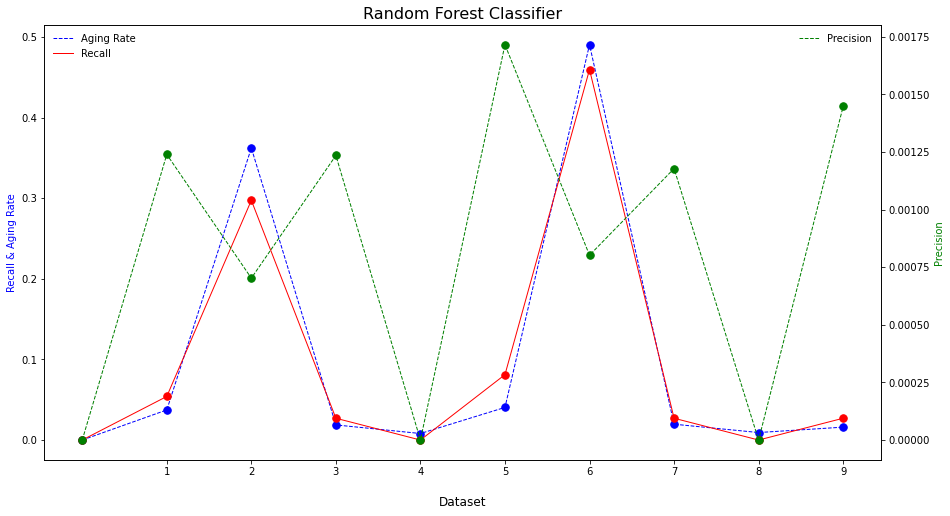

In [7]:
table_setC = runall_ForestC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'Random Forest Classifier')

In [8]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,479.923077,230843.0,481.0,0.0,0.0,37.0,43206.0,0.000000,0.000000,0.000000,NaN,NaN
dataset 1,1.000000,4774.0,4774.0,2.0,1612.0,35.0,41594.0,0.001239,0.054054,0.037324,1.448240,0.048398
dataset 2,1.000000,6276.0,6276.0,11.0,15652.0,26.0,27554.0,0.000702,0.297297,0.362209,0.820790,0.000000
dataset 3,1.000000,5278.0,5278.0,1.0,809.0,36.0,42397.0,0.001235,0.027027,0.018731,1.442876,0.024140
dataset 4,1.000000,4809.0,4809.0,0.0,350.0,37.0,42856.0,0.000000,0.000000,0.008094,0.000000,0.000000
dataset 5,1.002501,4810.0,4798.0,3.0,1746.0,34.0,41460.0,0.001715,0.081081,0.040446,2.004682,0.089203
dataset 6,0.758675,4810.0,6340.0,17.0,21187.0,20.0,22019.0,0.000802,0.459459,0.490345,0.937012,0.000000
dataset 7,1.000000,4810.0,4810.0,1.0,848.0,36.0,42358.0,0.001178,0.027027,0.019633,1.376596,0.023396
dataset 8,1.000000,4810.0,4810.0,0.0,402.0,37.0,42804.0,0.000000,0.000000,0.009296,0.000000,0.000000
dataset 9,10.000000,4810.0,481.0,1.0,690.0,36.0,42516.0,0.001447,0.027027,0.015979,1.691360,0.026758


### Regressor

In [ ]:
pr_dict, table_setR = runall_ForestR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                     thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'Random Forest Regressor')

In [ ]:
multiple_curve(3, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [9]:
savedate = '20211123'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'RandomForest'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'RandomForest')